In [1]:
import tensorflow as tf
import numpy as np
import keras
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
from keras.models import Sequential
import os
import time
import tensorflow_datasets as tfds

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)


In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

print(train_images.shape)

170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)


In [3]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
def process_images(image, label):
    image = tf.image.per_image_standardization(image)
    image = tf.image.resize(image, (224,224))
    return image, label

In [5]:
with strategy.scope():
  VGG =Sequential([
      tfl.Resizing(224,224),
      #Conv1
      tfl.Conv2D(64,3,strides=(1, 1),padding='same', activation = 'relu'),
      tfl.Conv2D(64,3,strides=(1, 1),padding='same', activation = 'relu'), 
      tfl.MaxPool2D(pool_size = (2,2), strides = (2,2)),
      #Conv2
      tfl.Conv2D(128,3,strides=(1, 1),padding='same', activation = 'relu'),
      tfl.Conv2D(128,3,strides=(1, 1),padding='same', activation = 'relu'), 
      tfl.MaxPool2D(pool_size = (2,2), strides = (2,2)),
      #Conv3
      tfl.Conv2D(256,3,strides=(1, 1),padding='same', activation = 'relu'),
      tfl.Conv2D(256,3,strides=(1, 1),padding='same', activation = 'relu'),
      tfl.Conv2D(256,1,strides=(1, 1),padding='same', activation = 'relu'), 
      tfl.MaxPool2D(pool_size = (2,2), strides = (2,2)),
      #Conv4
      tfl.Conv2D(512,3,strides=(1, 1),padding='same', activation = 'relu'),
      tfl.Conv2D(512,3,strides=(1, 1),padding='same', activation = 'relu'),
      tfl.Conv2D(512,1,strides=(1, 1),padding='same', activation = 'relu'), 
      tfl.MaxPool2D(pool_size = (2,2), strides = (2,2)),
      #Conv5
      tfl.Conv2D(512,3,strides=(1, 1),padding='same', activation = 'relu'),
      tfl.Conv2D(512,3,strides=(1, 1),padding='same', activation = 'relu'),
      tfl.Conv2D(512,1,strides=(1, 1),padding='same', activation = 'relu'), 
      tfl.MaxPool2D(pool_size = (2,2), strides = (2,2)),
      #FC1
      tfl.Flatten(),
      tfl.Dense(4096, activation = 'relu'),
      tfl.Dropout(0.5),
      #FC2
      tfl.Dense(4096,activation = 'relu'),
      tfl.Dropout(0.5),
      #FC3
      tfl.Dense(10)
      ])
  VGG.build((50000,224,224,3))
  VGG.compile( loss =keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer = 'adam', metrics = ['accuracy'])
  VGG.summary()

  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (50000, 224, 224, 3)      0         
                                                                 
 conv2d (Conv2D)             (50000, 224, 224, 64)     1792      
                                                                 
 conv2d_1 (Conv2D)           (50000, 224, 224, 64)     36928     
                                                                 
 max_pooling2d (MaxPooling2D  (50000, 112, 112, 64)    0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (50000, 112, 112, 128)    73856     
                                                                 
 conv2d_3 (Conv2D)           (50000, 112, 112, 128)    147584    
                                                        

In [6]:
history = VGG.fit(train_images, train_labels, batch_size = 128,epochs = 30, validation_data=(test_images, test_labels))

Epoch 1/30
391/391 [==============================] - 103s 211ms/step - loss: 2.3171 - accuracy: 0.2812 - val_loss: 1.6163 - val_accuracy: 0.4067
Epoch 2/30
391/391 [==============================] - 58s 149ms/step - loss: 1.4175 - accuracy: 0.4836 - val_loss: 1.1594 - val_accuracy: 0.5881
Epoch 3/30
391/391 [==============================] - 58s 149ms/step - loss: 1.0806 - accuracy: 0.6180 - val_loss: 0.9290 - val_accuracy: 0.6758
Epoch 4/30
391/391 [==============================] - 58s 149ms/step - loss: 0.8675 - accuracy: 0.6945 - val_loss: 0.8580 - val_accuracy: 0.7012
Epoch 5/30
391/391 [==============================] - 58s 150ms/step - loss: 0.7131 - accuracy: 0.7515 - val_loss: 0.7854 - val_accuracy: 0.7332
Epoch 6/30
391/391 [==============================] - 58s 149ms/step - loss: 0.5901 - accuracy: 0.7953 - val_loss: 0.7425 - val_accuracy: 0.7412
Epoch 7/30
391/391 [==============================] - 58s 149ms/step - loss: 0.4774 - accuracy: 0.8334 - val_loss: 0.7543 - val_a

In [7]:
def plothist(hist):
    plt.figure(1)



    plt.subplot(211)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')

    plt.tight_layout()


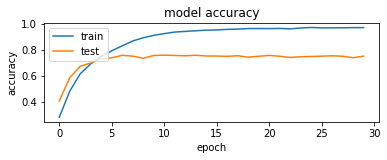

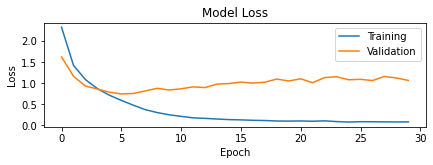

In [8]:
plothist(history)